In [112]:
import os
import sys
import re

project_root = "/root/work/tenset"
os.environ["TVM_HOME"] = f"{project_root}"
os.environ["TVM_LIBRARY_PATH"] = f"{project_root}/build"
if f"{project_root}/python" not in sys.path:
    sys.path.insert(0, f"{project_root}/python")

sys.path = [p for p in sys.path if not p.startswith(f"{project_root}/build")]
sys.path.append(f"{project_root}/build")
os.environ["LD_LIBRARY_PATH"] = f"{project_root}/build:" + os.environ.get("LD_LIBRARY_PATH", "")

In [113]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import numpy as np

class FeatureRegressionDataset(Dataset):
    def __init__(self, X, y, feature):
        if isinstance(X, np.ndarray):
            self.X = torch.from_numpy(X).float()
        else:
            self.X = X
        if isinstance(feature, np.ndarray):
            self.feature = torch.from_numpy(feature).float()
        else:
            self.feature = feature
        self.y = torch.from_numpy(y).float()
        # y shape이 (N,)이면 (N,1)로 바꿔주는 게 편할 때가 많음
        if self.y.ndim == 1:
            self.y = self.y.unsqueeze(1)
        if self.feature.ndim == 1:
            self.feature = self.feature.unsqueeze(1)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx], self.feature[idx]


class FeatureDataset(Dataset):
    def __init__(self, X, feature):
        if isinstance(X, np.ndarray):
            self.X = torch.from_numpy(X).float()
        else:
            self.X = X
        self.feature = torch.from_numpy(feature).float()
        # feature shape이 (N,)이면 (N,1)로 바꿔주는 게 편할 때가 많음
        if self.feature.ndim == 1:
            self.feature = self.feature.unsqueeze(1)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.feature[idx]


In [114]:
import numpy as np
import torch

# record_index
# vector_index
# diff_indices
# diff_values
# cost

json_diffs = np.load("../i_vectors_diffs.npz")
raw_input = json_diffs["diff_values"]

# input_data = json_diffs["diff_values"]
cost = -np.log(json_diffs["cost"])

In [115]:
import torch
from sklearn.model_selection import train_test_split

def transform_schedule(x_int, mean=None, std=None, eps=1e-6):
    """
    스케줄 파라미터 int 텐서를 log-scale + zero-flag로 변환

    Args:
        x_int: (B, D) int 텐서. 예: 0, 1, 2, 4, 8, ..., 1024
        mean, std: (1, D) 형태의 텐서. None이면 입력에서 계산해서 반환.
        eps: 분산 0 방지용 작은 값.

    Returns:
        x_cont: (B, 2*D) float 텐서. [v_norm, is_zero] concat
        mean, std: (1, D) float 텐서. 나중에 validation/test에도 reuse
    """
    # int → float
    x_int = torch.tensor(x_int)
    x = x_int.to(torch.float32)

    # zero flag
    is_zero = (x_int == 0).to(torch.float32)  # (B, D)

    # log2 변환 (0은 일단 0으로 두고 mask)
    v = torch.zeros_like(x, dtype=torch.float32)  # (B, D)
    mask = (x_int > 0)
    v[mask] = torch.log2(x[mask])

    # mean / std 없으면 전체 batch 기준으로 계산 (보통은 train 전체로 미리 계산)
    if mean is None or std is None:
        mean = v.mean(dim=0, keepdim=True)           # (1, D)
        std = v.std(dim=0, keepdim=True) + eps       # (1, D)

    # 정규화
    v_norm = (v - mean) / std   # (B, D)

    # v_norm과 is_zero concat → (B, 2D)
    x_cont = torch.cat([v_norm, is_zero], dim=-1)

    return x_cont, mean, std



In [116]:
import sys
sys.path.append("/root/work/tenset/scripts")

from tvm import auto_scheduler
from print_programs import return_program
from tvm.auto_scheduler.feature import get_per_store_features_from_file
from make_dataset import load_and_register_tasks
import numpy as np

json_file = "/root/work/tenset/dataset/measure_records_tenset/k80/([0bcb8746286db050cd088f375c85372d,1,64,64,128,6,6,32,128,1,64,64,32],cuda).json"

tasks = load_and_register_tasks()
inputs, results = auto_scheduler.RecordReader(json_file).read_lines()
raw_features, raw_normalized_throughputs, task_ids, min_latency = get_per_store_features_from_file(json_file, 10000)

KeyboardInterrupt: 

In [ ]:
features = []
for feature, throughput in zip(raw_features, raw_normalized_throughputs):
    if throughput > 1.0e-10:
        features.append(feature)


features = np.array(features, dtype=np.float32)
features_mean = np.mean(features, axis=1)
features_mean = torch.tensor(features_mean, dtype=torch.float32)
# (3464, 8, features_dim) -> (3464, features_dim)

features_mean = features_mean.view(features_mean.shape[0], -1)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class VAE_feature_head(nn.Module):
    def __init__(self, input_dim, feature_dim, latent_dim=16, hidden_dim=128):
        """
        input_dim: 2 * D (v_norm + is_zero concat한 차원)
        latent_dim: latent space 차원
        hidden_dim: MLP hidden 크기
        """
        super().__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            
            # 출력은 연속값이니까 activation 없이 그대로
        )

        self.feature_predictor = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, feature_dim),  # features.shape[1]는 feature 차원
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def predict_feature(self, z):
        return self.feature_predictor(z)

    def forward(self, x, use_mean=True):
        mu, logvar = self.encode(x)
        if use_mean:
            z = mu
        else:
            z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        feature_pred = self.predict_feature(z)
        return x_recon, mu, logvar, z, feature_pred

def vae_feature_loss(x_recon, x, mu, logvar, feature_pred, feature, alpha_recon=0, alpha_feature=0, beta=1.0):
    """
    x, x_recon: (B, input_dim)
    mu, logvar: (B, latent_dim)

    beta: KL 가중치 (β-VAE 스타일로 조절)
    """
    # reconstruction loss: MSE
    recon_loss = F.mse_loss(x_recon, x, reduction="mean")

    feature_loss = F.mse_loss(feature_pred, feature, reduction="mean")

    # KL divergence: D_KL(q(z|x) || N(0, I))
    kl = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    loss = alpha_recon * recon_loss + beta * kl + alpha_feature * feature_loss
    return loss, recon_loss, kl, feature_loss



In [142]:
from sklearn.preprocessing import StandardScaler


input_data = np.log(json_diffs["diff_values"]+1e-8)

scaler = StandardScaler()
input_data_scaled = scaler.fit_transform(input_data)
feature_scaled = scaler.fit_transform(features_mean)

X_train, X_val, y_train, y_val, feature_train, feature_val = train_test_split(
    input_data_scaled, cost, feature_scaled,  test_size=0.2, random_state=42
)

# input_data, mean, std = transform_schedule(json_diffs["diff_values"])


In [208]:
def seed_everything(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    

In [ ]:
from sklearn.metrics import r2_score
import itertools
import torch
import pandas as pd
# 예시 세팅

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


X_train, X_val, y_train, y_val, feature_train, feature_val = train_test_split(
    input_data_scaled, cost, feature_scaled,  test_size=0.2, random_state=42
)



train_dataset = FeatureDataset(X_train, feature_train)
val_dataset   = FeatureDataset(X_val,   feature_val)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=512, shuffle=False)



input_dim = X_train.shape[-1]
latent_dim = 64
hidden_dim = 256







hyperparameter = {
    'beta': [0.001, 0.01, 0.1],
    'alpha_recon': [0.1],
    'alpha_feature': [1.0],
    'latent_dim': [32, 64],
    'lr': [1e-3, 1e-4],

    'seed': [2023, 2024, 2025],
}

cnt = 0
epochs = 300

# 시드 여러 번 시도해서 평균, 표준편차 계산
results = []

for vals in itertools.product(*hyperparameter.values()):
    (beta, noise_std, alpha_recon, alpha_feature, latent_dim, lr, seed) = vals
    cnt += 1
    print("=============================================")
    print(f"Experiment {cnt}/{len(list(itertools.product(*hyperparameter.values())))}")
    print(f"beta={beta}, alpha_recon={alpha_recon}, alpha_feature={alpha_feature},\nepochs={epochs}, latent_dim={latent_dim}, hidden_dim={hidden_dim}, lr={lr}, seed={seed}")

    seed_everything(seed)

    vae = VAE_feature_head(input_dim=input_dim, feature_dim=feature_train.shape[-1], latent_dim=latent_dim, hidden_dim=hidden_dim).to(device)
    optimizer = torch.optim.Adam(vae.parameters(), lr=lr)

    # early stopping
    best_val_loss = float('inf')
    patience = 30
    patience_counter = 0

    for epoch in range(1, epochs+1):
        vae.train()
        for x_batch, feature_batch in train_loader:
            x_batch = x_batch.to(device)  # (N, D)
            feature_batch = feature_batch.to(device)

            x_recon, mu, logvar, z, feature_pred = vae(x_batch, use_mean=False)

            loss, recon_loss, kl, feature_loss = vae_feature_loss(x_recon, x_batch, mu, logvar, feature_pred, feature_batch, alpha_recon=alpha_recon, alpha_feature=alpha_feature, beta=beta)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        vae.eval()
        for x_batch, feature_batch in val_loader:
            x_batch = x_batch.to(device)
            feature_batch = feature_batch.to(device)
            x_recon, mu, logvar, z, feature_pred = vae(x_batch, use_mean=True)
            val_loss, val_recon_loss, val_kl, val_feature_loss = vae_feature_loss(x_recon, x_batch, mu, logvar, feature_pred, feature_batch, alpha_recon=alpha_recon, alpha_feature=alpha_feature, beta=beta)
            val_recon_r2 = r2_score(x_batch.detach().cpu().numpy(), x_recon.detach().cpu().numpy())
            val_feature_r2 = r2_score(feature_batch.detach().cpu().numpy(), feature_pred.detach().cpu().numpy())

        if val_loss < best_val_loss:
            best_val_loss = val_loss.item()
            patience_counter = 0
        else:
            patience_counter += 1
            
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch}")
                break
    print(f"epoch {epoch}: loss={loss.item():.4f}, recon={recon_loss.item():.4f}, feature={feature_loss.item():.4f}, kl={kl.item():.4f}")
    print(f"epoch {epoch}: val loss={val_loss.item():.4f}, val recon={val_recon_loss.item():.4f}, val feature={val_feature_loss.item():.4f}, val kl={val_kl.item():.4f}")

    print(f"Recon R2 : {val_recon_r2}, Feature R2 : {val_feature_r2}")
    
    results.append({
        "beta": beta,
        "alpha_recon": alpha_recon,
        "alpha_feature": alpha_feature,
        "latent_dim": latent_dim,
        "hidden_dim": hidden_dim,
        "lr": lr,
        "seed": seed,
        "best_val_loss": best_val_loss,
        "final_val_recon_r2": val_recon_r2,
        "final_val_feature_r2": val_feature_r2,
    })
    print("Next experiment..\n")


Experiment 1/432
beta=0.001, noise_std=0.001, alpha_recon=0.1, alpha_feature=0.1,
epochs=300, latent_dim=32, hidden_dim=256, lr=0.001, seed=2023
epoch 300: loss=0.0051, recon=0.0105, feature=0.0142, kl=2.6542
epoch 300: val loss=0.0102, val recon=0.0288, val feature=0.0465, val kl=2.6444
Recon R2 : 0.971184121504381, Feature R2 : 0.4291942431317978
Next experiment..

Experiment 2/432
beta=0.001, noise_std=0.001, alpha_recon=0.1, alpha_feature=0.1,
epochs=300, latent_dim=32, hidden_dim=256, lr=0.001, seed=2024
epoch 300: loss=0.0050, recon=0.0100, feature=0.0138, kl=2.6531
epoch 300: val loss=0.0103, val recon=0.0300, val feature=0.0463, val kl=2.6714
Recon R2 : 0.9699798979759202, Feature R2 : 0.4295778662486734
Next experiment..

Experiment 3/432
beta=0.001, noise_std=0.001, alpha_recon=0.1, alpha_feature=0.1,
epochs=300, latent_dim=32, hidden_dim=256, lr=0.001, seed=2025
epoch 300: loss=0.0050, recon=0.0089, feature=0.0143, kl=2.6619
epoch 300: val loss=0.0101, val recon=0.0294, val 

In [235]:

results_df = pd.DataFrame(results)
results_df = results_df.drop(columns=['noise_std'])
# 시드를 하나로 묶어서 평균, 표준편차 계산
grouped = results_df.groupby(['beta', 'alpha_recon', 'alpha_feature', 'latent_dim', 'hidden_dim', 'lr']).agg(
    mean_val_loss = ('best_val_loss', 'mean'),
    std_val_loss = ('best_val_loss', 'std'),
    mean_recon_r2 = ('final_val_recon_r2', 'mean'),
    std_recon_r2 = ('final_val_recon_r2', 'std'),
    mean_feature_r2 = ('final_val_feature_r2', 'mean'),
    std_feature_r2 = ('final_val_feature_r2', 'std'),
    
).reset_index()

grouped = grouped.round({
    'mean_val_loss': 4,
    'std_val_loss': 4,
    'mean_recon_r2': 4,
    'std_recon_r2': 4,
    'mean_feature_r2': 4,
    'std_feature_r2': 4,
})

grouped.to_csv("vae_feature_head_hyperparameter_search_results.csv", index=False)

In [ ]:
from sklearn.metrics import r2_score
import itertools
import torch
import pandas as pd
# 예시 세팅

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


X_train, X_val, y_train, y_val, feature_train, feature_val = train_test_split(
    input_data_scaled, cost, feature_scaled,  test_size=0.2, random_state=42
)



train_dataset = FeatureDataset(X_train, feature_train)
val_dataset   = FeatureDataset(X_val,   feature_val)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=512, shuffle=False)



input_dim = X_train.shape[-1]
latent_dim = 64
hidden_dim = 256







hyperparameter = {
    'beta': [0.01],
    'alpha_recon': [0.1],
    'alpha_feature': [1.0],
    'latent_dim': [64],
    'lr': [1e-3],
}

cnt = 0
epochs = 300


for vals in itertools.product(*hyperparameter.values()):
    (beta, alpha_recon, alpha_feature, latent_dim, lr) = vals
    cnt += 1
    print("=============================================")
    print(f"Experiment {cnt}/{len(list(itertools.product(*hyperparameter.values())))}")
    print(f"beta={beta}, alpha_recon={alpha_recon}, alpha_feature={alpha_feature},\nepochs={epochs}, latent_dim={latent_dim}, hidden_dim={hidden_dim}, lr={lr}, seed={seed}")

    seed_everything(42)

    vae = VAE_feature_head(input_dim=input_dim, latent_dim=latent_dim, hidden_dim=hidden_dim).to(device)
    optimizer = torch.optim.Adam(vae.parameters(), lr=lr)

    # early stopping
    best_val_loss = float('inf')
    patience = 30
    patience_counter = 0

    for epoch in range(1, epochs+1):
        vae.train()
        for x_batch, feature_batch in train_loader:
            x_batch = x_batch.to(device)  # (N, D)
            feature_batch = feature_batch.to(device)

            x_recon, mu, logvar, z, feature_pred = vae(x_batch, use_mean=False)

            loss, recon_loss, kl, feature_loss = vae_feature_loss(x_recon, x_batch, mu, logvar, feature_pred, feature_batch, alpha_recon=alpha_recon, alpha_feature=alpha_feature, beta=beta)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        vae.eval()
        for x_batch, feature_batch in val_loader:
            x_batch = x_batch.to(device)
            feature_batch = feature_batch.to(device)
            x_recon, mu, logvar, z, feature_pred = vae(x_batch, use_mean=True)
            val_loss, val_recon_loss, val_kl, val_feature_loss = vae_feature_loss(x_recon, x_batch, mu, logvar, feature_pred, feature_batch, alpha_recon=alpha_recon, alpha_feature=alpha_feature, beta=beta)
            val_recon_r2 = r2_score(x_batch.detach().cpu().numpy(), x_recon.detach().cpu().numpy())
            val_feature_r2 = r2_score(feature_batch.detach().cpu().numpy(), feature_pred.detach().cpu().numpy())

        if val_loss < best_val_loss:
            best_val_loss = val_loss.item()
            patience_counter = 0
        else:
            patience_counter += 1
            
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch}")
                break
    print(f"epoch {epoch}: loss={loss.item():.4f}, recon={recon_loss.item():.4f}, feature={feature_loss.item():.4f}, kl={kl.item():.4f}")
    print(f"epoch {epoch}: val loss={val_loss.item():.4f}, val recon={val_recon_loss.item():.4f}, val feature={val_feature_loss.item():.4f}, val kl={val_kl.item():.4f}")

    print(f"Recon R2 : {val_recon_r2}, Feature R2 : {val_feature_r2}")


Experiment 1/1
beta=0.01, alpha_recon=1.0, alpha_feature=1.0,
epochs=300, latent_dim=64, hidden_dim=256, lr=0.001, seed=2025
epoch 300: loss=0.0440, recon=0.0086, feature=0.0121, kl=2.3310
epoch 300: val loss=0.0877, val recon=0.0211, val feature=0.0434, val kl=2.3236
Recon R2 : 0.978883535645712, Feature R2 : 0.4322361224188036


In [ ]:
class VAECostPredictor(nn.Module):
    """
    VAE 기반 Cost Regression 모델
    
    구조:
    - input → segment_encoder → segment_sum → VAE encoder → z → cost_predictor → cost
    
    특징:
    - Pretrained VAE encoder를 finetune (작은 learning rate)
    - Cost predictor는 더 큰 learning rate로 학습
    - 전체 forward 경로가 완전히 미분 가능 (detach, stop_grad 없음)
    """
    
    def __init__(self, input_dim, hidden_dim=256, latent_dim=64, 
                 predictor_hidden=256, predictor_layers=2, dropout=0.1, use_feature=True):
        super(VAECostPredictor, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        
        # ========== Cost Predictor (새로 학습) ==========
        predictor_modules = []
        current_dim = latent_dim
        for i in range(predictor_layers):
            predictor_modules.extend([
                nn.Linear(current_dim, predictor_hidden),
                nn.ReLU(),
                nn.Dropout(dropout) if i < predictor_layers - 1 else nn.Identity(),
            ])
            current_dim = predictor_hidden
        predictor_modules.append(nn.Linear(predictor_hidden, 1))
        
        self.cost_predictor = nn.Sequential(*predictor_modules)

        self.use_feature = use_feature
        self.feature_predictor = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, features.shape[-1]),  # features.shape[1]는 feature 차원
        )
        
    
    def encode(self, input_data):
        """
        Full encoding path: features → z
        완전히 미분 가능
        """
                
        # VAE Encoder
        h = self.encoder(input_data)
        
        mean = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        
        return mean, logvar, input_data
    
    def reparameterize(self, mean, logvar):
        """Reparameterization trick - 미분 가능"""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std
    
    def predict_cost(self, z):
        """z → cost prediction - 완전히 미분 가능"""
        return self.cost_predictor(z).squeeze(-1)
    
    def predict_feature(self, z):
        return self.feature_predictor(z)
    
    def forward(self, input_data, use_mean=True):
        """
        Forward pass: input → z → cost
        
        Args:
            use_mean: True면 reparameterize 대신 mean 사용 (inference용)
        
        Returns:
            cost_pred: 예측된 cost
            mean: latent mean
            logvar: latent log-variance
            z: sampled/mean latent vector
        """
        mean, logvar, input_data = self.encode(input_data)
        
        if use_mean:
            z = mean  # Inference시 deterministic
        else:
            z = self.reparameterize(mean, logvar)  # Training시 stochastic
        
        cost_pred = self.predict_cost(z)
        
        return cost_pred, mean, logvar, z
    
    def get_encoder_params(self):
        """Encoder 파라미터 (작은 lr)"""
        encoder_params = []
        encoder_params.extend(self.encoder.parameters())
        encoder_params.extend(self.fc_mu.parameters())
        encoder_params.extend(self.fc_logvar.parameters())
        return encoder_params
    
    def get_cost_predictor_params(self):
        """Predictor 파라미터 (큰 lr)"""
        return self.cost_predictor.parameters()
    
    def get_feature_predictor_params(self):
        """Feature Predictor 파라미터"""
        return self.feature_predictor.parameters()

    def load_pretrained_encoder(self, checkpoint):
        """Pretrained VAE encoder 가중치 로드"""
        

        vae_state = checkpoint
        
        # 매칭되는 키만 로드
        encoder_keys = ['encoder', 'fc_mu', 'fc_logvar', 'feature_predictor', ']']
        own_state = self.state_dict()
        
        loaded_keys = []
        for name, param in vae_state.items():
            if any(name.startswith(k) for k in encoder_keys):
                if name in own_state and own_state[name].shape == param.shape:
                    own_state[name].copy_(param)
                    loaded_keys.append(name)
        
        # print(f"Loaded {len(loaded_keys)} parameters from pretrained VAE")
        # return loaded_keys

def pair_accuracy(cost_pred, labels):
    """
    cost_pred, labels: (B,) 텐서
    """
    n_samples = min(1000, len(cost_pred))
    sample_indices = np.random.choice(len(cost_pred), n_samples, replace=False)

    with torch.no_grad():
        correct = 0
        total = 0
        for i in range(n_samples):
            for j in range(i + 1, n_samples):
                idx_i = sample_indices[i]
                idx_j = sample_indices[j]
                pred_diff = cost_pred[idx_i] - cost_pred[idx_j]
                true_diff = labels[idx_i] - labels[idx_j]
                if (pred_diff * true_diff) > 0:
                    correct += 1
                total += 1
        accuracy = correct / total if total > 0 else 0.0
    return accuracy


In [238]:
def reg_loss_fn(cost_pred, cost_true, loss_type='mse'):
    """
    기본 회귀 손실 (MSE 또는 MAE)
    """
    if loss_type == 'mse':
        return F.mse_loss(cost_pred, cost_true)
    else:  # mae
        return F.l1_loss(cost_pred, cost_true)


def pair_loss_fn(cost_pred, cost_true, margin=0.1):
    """
    Pairwise ranking loss: 실제 cost 순서를 예측이 유지하도록.
    cost_true[i] < cost_true[j] 이면 cost_pred[i] < cost_pred[j] + margin
    """
    batch_size = cost_pred.size(0)
    if batch_size < 2:
        return torch.tensor(0.0, device=cost_pred.device)
    
    # 모든 쌍에 대해 ranking loss 계산
    idx = torch.arange(batch_size, device=cost_pred.device)
    i_idx, j_idx = torch.meshgrid(idx, idx, indexing='ij')
    mask = i_idx < j_idx  # upper triangular only
    
    pred_i = cost_pred[i_idx[mask]]
    pred_j = cost_pred[j_idx[mask]]
    true_i = cost_true[i_idx[mask]]
    true_j = cost_true[j_idx[mask]]
    
    # label: 1 if true_i < true_j, -1 otherwise
    labels = torch.sign(true_j - true_i).float()
    
    # Margin ranking loss
    loss = F.margin_ranking_loss(pred_j.view(-1), pred_i.view(-1), labels.view(-1), margin=margin)
    return loss


def smooth_loss_fn(model, z, noise_std=0.1):
    """
    Smoothness loss: z에 작은 노이즈를 더했을 때 예측이 크게 변하지 않도록.
    """
    z_noisy = z + noise_std * torch.randn_like(z)
    
    cost_original = model.predict_cost(z)
    cost_noisy = model.predict_cost(z_noisy)
    
    smooth_loss = F.mse_loss(cost_original, cost_noisy)
    return smooth_loss


def kld_loss_fn(mean, logvar):
    """
    KL Divergence: q(z|x) || N(0, I)
    """
    kld = -0.5 * torch.mean(1 + logvar - mean.pow(2) - logvar.exp())
    return kld

def feature_loss_fn(use_feature, feature_pred, feature_true, coef=0.1):
    """
    Feature 예측 손실 (MSE)
    """
    if not use_feature:
        return torch.tensor(0.0, device=feature_pred.device)
    return F.mse_loss(feature_pred, feature_true) * coef


def compute_total_loss(model, cost_pred, mean, logvar, z, labels, feature, config, return_components=True):
    """
    Total loss 계산 (Segment 기반 데이터용).
    total_loss = reg_loss + λ_pair * pair_loss + γ * smooth_loss + β * kld_loss
    """
    
    # Individual losses
    reg = reg_loss_fn(cost_pred, labels, loss_type=config.get('loss_type', 'mse'))
    pair = pair_loss_fn(cost_pred.view(-1), labels.view(-1), margin=config.get('margin', 0.1))
    smooth = smooth_loss_fn(model, z, noise_std=config.get('noise_std', 0.1))
    kld = kld_loss_fn(mean, logvar)
    feature_loss = feature_loss_fn(model.use_feature, model.predict_feature(z), feature, coef=config.get('alpha', 0.1))
    
    # Weighted sum
    total = config['lambda_reg'] * reg + config['lambda_pair'] * pair + config['gamma'] * smooth + config['beta'] * kld + feature_loss
    
    if return_components:
        return total, {
            'reg_loss': reg.item(),
            'pair_loss': pair.item(),
            'smooth_loss': smooth.item(),
            'kld_loss': kld.item(),
            'feature_loss': feature_loss.item(),
        }
    return total

In [239]:
input_data = np.log(json_diffs["diff_values"]+1e-8)
costs = -np.log(json_diffs["cost"])


scaler = StandardScaler()
input_data_scaled = scaler.fit_transform(input_data)
features_scaled = scaler.fit_transform(features_mean)

# X_train_reg, X_val_reg, y_train_reg, y_val_reg = train_test_split(
#     input_data_scaled, costs, test_size=0.2, random_state=42
# )

X_train_reg, X_val_reg, y_train_reg, y_val_reg, feature_train, feature_val = train_test_split(
    input_data_scaled, costs, features_scaled,  test_size=0.2, random_state=42
)

train_dataset = FeatureRegressionDataset(X_train_reg, y_train_reg, feature_train)
val_dataset   = FeatureRegressionDataset(X_val_reg,   y_val_reg, feature_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
val_loader   = DataLoader(val_dataset,   batch_size=256, shuffle=False)





In [251]:
input_data = np.log(json_diffs["diff_values"]+1e-8)
costs = -np.log(json_diffs["cost"])


train_size = 64

np.random.seed(42)
random_indices = np.random.permutation(len(input_data))
# random_indices = np.arange(len(input_data))

scaler = StandardScaler()
input_data_scaled = scaler.fit_transform(input_data)
features_scaled = scaler.fit_transform(features_mean)
costs_scaled = (costs - costs.mean()) / (costs.std() + 1e-8)

X_train = input_data_scaled[random_indices[:train_size]]
X_val = input_data_scaled[random_indices[train_size:]]
y_train = costs[random_indices[:train_size]]
y_val = costs[random_indices[train_size:]]

train_dataset = FeatureRegressionDataset(X_train, y_train, features_scaled[random_indices[:train_size]])
val_dataset   = FeatureRegressionDataset(X_val,   y_val, features_scaled[random_indices[train_size:]])

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=False)
val_loader   = DataLoader(val_dataset,   batch_size=512, shuffle=False)

y_mean = y_train.mean()
y_std = y_train.std() + 1e-8  # 0 나누기 방지용 작은 값 추가
print(f"y_train mean: {y_mean}, std: {y_std}")

y_train mean: 6.333581531911031, std: 1.3555901482101775


In [254]:
import itertools
import pandas as pd
input_dim = X_train.shape[-1]
latent_dim = 64
hidden_dim = 256


hyperparameter = {
    # 'lambda_reg' : [0.01, 0.1],
    # 'lambda_pair': [2.0, 3.0],
    # 'margin_scale': [0.3],
    # 'gamma': [0.01, 0.1],
    # 'beta': [0.01, 0.1],
    # 'noise_std': [0.001, 0.01],
    # 'alpha': [1e-4, 1e-3],

    # 'encoder_lr': [5e-5],
    # 'feature_predictor_lr': [1e-4, 1e-2],
    # 'cost_predictor_lr': [1e-2],
    # 'seed': [True, False],
    # 'use_feature': [2023, 2024],


    'lambda_reg' : [0.01],
    'lambda_pair': [2.0],
    'margin_scale': [0.3],
    'gamma': [0.01],
    'beta': [0.01],
    'noise_std': [0.01],
    'alpha': [1e-4],
    'encoder_lr': [5e-5],
    'feature_predictor_lr': [1e-4, 1e-2],
    'cost_predictor_lr': [1e-2],
    'use_feature': [True],
    'seed': [2023, 2024],
    
}



all_reg_results = []
cnt = 0

for vals in itertools.product(*hyperparameter.values()):
    
    
    (lambda_reg, lambda_pair, margin_scale, gamma, beta, noise_std, alpha,
     encoder_lr, feature_predictor_lr, cost_predictor_lr, seed, use_feature) = vals
    
    cnt += 1
    print("=============================================")
    print(f"Experiment {cnt}/{len(list(itertools.product(*hyperparameter.values())))}")
    print(f"lambda_reg={lambda_reg}, lambda_pair={lambda_pair}, margin_scale={margin_scale}, gamma={gamma}, beta={beta}, noise_std={noise_std}, alpha={alpha},\nencoder_lr={encoder_lr}, feature_predictor_lr={feature_predictor_lr}, cost_predictor_lr={cost_predictor_lr}, seed={seed}, use_feature={use_feature}")

    config = {
                'encoder_lr': encoder_lr,
                'feature_predictor_lr': feature_predictor_lr,
                'cost_predictor_lr': cost_predictor_lr,
                'lambda_reg' : lambda_reg,
                'lambda_pair': lambda_pair,
                'gamma': gamma,
                'beta': beta,
                'margin': margin_scale * y_std,
                'noise_std': noise_std,
                'alpha': alpha,
                'loss_type': 'mse'
            }


    torch.manual_seed(seed)

    vae_cost_model = VAECostPredictor(input_dim=input_dim, 
                                    latent_dim=latent_dim, 
                                    hidden_dim=hidden_dim, 
                                    predictor_layers=2,
                                    dropout=0.1, use_feature=use_feature).to(device)
    # vae_cost_model.load_pretrained_encoder(vae.state_dict())


    optimizer = torch.optim.AdamW([
            {'params': vae_cost_model.get_encoder_params(), 'lr': config['encoder_lr']},
            {'params': vae_cost_model.get_feature_predictor_params(), 'lr': config['feature_predictor_lr']},
            {'params': vae_cost_model.get_cost_predictor_params(), 'lr': config['cost_predictor_lr']}
        ], weight_decay=1e-5)


    epochs = 1000
    best_val_loss = float('inf')
    patience = 30
    patience_counter = 0

    for epoch in range(1, epochs+1):
        vae_cost_model.train()
        for x_batch, labels, features in train_loader:
            x_batch = x_batch.to(device)
            labels = labels.to(device).squeeze(-1)
            features = features.to(device)
            
        
            cost_pred, mean, logvar, z = vae_cost_model(x_batch, use_mean=False)

            train_loss, train_components = compute_total_loss(vae_cost_model, 
                                                    cost_pred, mean, logvar, z, labels, features, config)

            optimizer.zero_grad()
            train_loss.backward()
            torch.nn.utils.clip_grad_norm_(vae_cost_model.parameters(), max_norm=1.0)
            optimizer.step()
            
        

        if epoch % epochs == 0:
            vae_cost_model.eval()
            all_preds = []
            all_labels = []
            for x_batch, labels, features in val_loader:
                x_batch = x_batch.to(device)
                labels = labels.to(device).squeeze(-1)
                features = features.to(device)

                cost_pred, mean, logvar, z = vae_cost_model(x_batch, use_mean=True)

                val_loss, val_components = compute_total_loss(vae_cost_model, cost_pred, mean, logvar, z, labels, features, config)
            val_reg_r2 = r2_score(cost_pred.detach().cpu().numpy(), labels.detach().cpu().numpy())
                
            print(f"Train loss epoch {epoch} : reg={train_components['reg_loss']: .4f} rank={train_components['pair_loss']: .4f} kl={train_components['kld_loss']: .4f}")
            print(f"Val loss epoch {epoch}: reg={val_components['reg_loss']: .4f} rank={val_components['pair_loss']: .4f} kl={val_components['kld_loss']: .4f}")
            
            print(f"Regression R2 : {val_reg_r2:.4f}, ", end='')
        
        # rank r2 계산
        if epoch == epochs:
            all_preds = []
            all_labels = []
            for x_batch, labels, features in val_loader:
                x_batch = x_batch.to(device)
                labels = labels.to(device).squeeze(-1)
                features = features.to(device)
                cost_pred, mean, logvar, z = vae_cost_model(x_batch, use_mean=True)
                all_preds.append(cost_pred.detach().cpu().numpy())
                all_labels.append(labels.detach().cpu().numpy())
            all_preds = np.concatenate(all_preds, axis=0)
            all_labels = np.concatenate(all_labels, axis=0)
            val_rank_r2 = pair_accuracy(all_preds, all_labels)
            print(f"Rank R2 : {val_rank_r2:.4f}")
    all_reg_results.append({
        "lambda_reg": lambda_reg,
        "lambda_pair": lambda_pair,
        "margin_scale": margin_scale,
        "gamma": gamma,
        "beta": beta,
        "noise_std": noise_std,
        "alpha": alpha,
        "encoder_lr": encoder_lr,
        "feature_predictor_lr": feature_predictor_lr,
        "cost_predictor_lr": cost_predictor_lr,
        "use_feature": use_feature,
        "seed": seed,
        "reg_r2": val_reg_r2,
        "rank_r2": val_rank_r2,
    })
    

Experiment 1/4
lambda_reg=0.01, lambda_pair=2.0, margin_scale=0.3, gamma=0.01, beta=0.01, noise_std=0.01, alpha=0.0001,
encoder_lr=5e-05, feature_predictor_lr=0.0001, cost_predictor_lr=0.01, seed=True, use_feature=2023
Train loss epoch 1000 : reg= 0.7724 rank= 0.0187 kl= 0.7057
Val loss epoch 1000: reg= 1.9787 rank= 0.4563 kl= 0.5683
Regression R2 : 0.2944, Rank R2 : 0.7516
Experiment 2/4
lambda_reg=0.01, lambda_pair=2.0, margin_scale=0.3, gamma=0.01, beta=0.01, noise_std=0.01, alpha=0.0001,
encoder_lr=5e-05, feature_predictor_lr=0.0001, cost_predictor_lr=0.01, seed=True, use_feature=2024
Train loss epoch 1000 : reg= 0.7724 rank= 0.0187 kl= 0.7057
Val loss epoch 1000: reg= 1.9787 rank= 0.4563 kl= 0.5683
Regression R2 : 0.2944, Rank R2 : 0.7541
Experiment 3/4
lambda_reg=0.01, lambda_pair=2.0, margin_scale=0.3, gamma=0.01, beta=0.01, noise_std=0.01, alpha=0.0001,
encoder_lr=5e-05, feature_predictor_lr=0.01, cost_predictor_lr=0.01, seed=True, use_feature=2023
Train loss epoch 1000 : reg= 

In [249]:

reg_results_df = pd.DataFrame(all_reg_results)
# seed랑 use_feature 이름 바뀌어서 다시 맞추기
reg_results_df = reg_results_df.rename(columns={"use_feature": "seed", "seed":"use_feature"})


# 시드를 하나로 묶어서 평균, 표준편차 계산
grouped = reg_results_df.groupby(['lambda_reg', 'lambda_pair', 'margin_scale', 'gamma', 'beta', 'noise_std', 'alpha', 'encoder_lr', 'feature_predictor_lr', 'cost_predictor_lr', 'use_feature']).agg(
    mean_reg_r2 = ('reg_r2', 'mean'),
    std_reg_r2 = ('reg_r2', 'std'),
    mean_rank_r2 = ('rank_r2', 'mean'),
    std_rank_r2 = ('rank_r2', 'std'),
).reset_index()

grouped = grouped.round({
    'mean_reg_r2': 4,
    'std_reg_r2': 4,
    'mean_rank_r2': 4,
    'std_rank_r2': 4,
})

grouped.to_csv("vae_feature_guided_reg_featlr2.csv", index=False)

In [ ]:
for metric in ["val_reg_r2", "val_rank_r2"]:
    print(f"Metric: {metric}")
    all_values = []
    for seed in hyperparameter['seed']:
        values = history[seed][metric]
        all_values.extend(values)
        mean_val = np.mean(values)
        std_val = np.std(values)
    
    overall_mean = np.mean(all_values)
    overall_std = np.std(all_values)
    print(f"Overall: Mean={overall_mean:.4f}, Std={overall_std:.4f}")
    

Metric: val_reg_r2
  Seed 2000: Mean=0.5778, Std=0.0018
  Seed 2001: Mean=0.5438, Std=0.0209
  Seed 2002: Mean=0.5528, Std=0.0101
  Seed 2003: Mean=0.5714, Std=0.0043
  Seed 2004: Mean=0.5623, Std=0.0007
  Seed 2005: Mean=0.5557, Std=0.0066
  Seed 2006: Mean=0.5637, Std=0.0160
  Seed 2007: Mean=0.5394, Std=0.0026
  Seed 2008: Mean=0.5278, Std=0.0007
  Seed 2009: Mean=0.5703, Std=0.0074
Overall: Mean=0.5565, Std=0.0178
Metric: val_rank_r2
  Seed 2000: Mean=0.8089, Std=0.0006
  Seed 2001: Mean=0.8063, Std=0.0007
  Seed 2002: Mean=0.8098, Std=0.0012
  Seed 2003: Mean=0.8076, Std=0.0008
  Seed 2004: Mean=0.8029, Std=0.0108
  Seed 2005: Mean=0.8068, Std=0.0026
  Seed 2006: Mean=0.8109, Std=0.0020
  Seed 2007: Mean=0.8092, Std=0.0065
  Seed 2008: Mean=0.7971, Std=0.0036
  Seed 2009: Mean=0.8064, Std=0.0029
Overall: Mean=0.8066, Std=0.0058


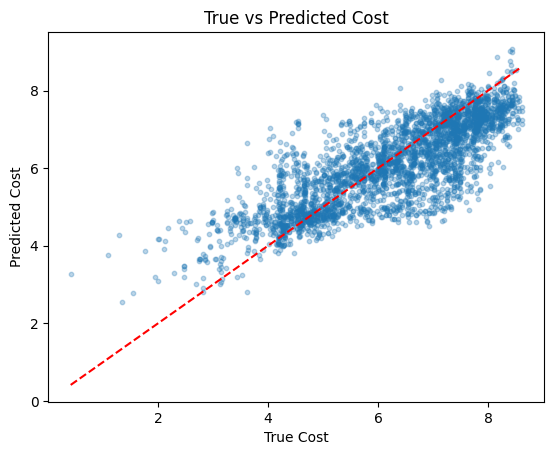

In [ ]:
# true, pred cost 시각화

import matplotlib.pyplot as plt

plt.scatter(all_labels, all_preds, alpha=0.3, s=10)
plt.xlabel("True Cost")
plt.ylabel("Predicted Cost")
plt.title("True vs Predicted Cost")
plt.plot([all_labels.min(), all_labels.max()], [all_labels.min(), all_labels.max()], 'r--')  # y=x 선

plt.show()


In [163]:
enc_params = sum(p.numel() for p in vae_cost_model.get_encoder_params())
feature_params = sum(p.numel() for p in vae_cost_model.get_feature_predictor_params())
cost_params = sum(p.numel() for p in vae_cost_model.get_cost_predictor_params())
print(f"\n모델 파라미터 수:")
print(f"   Encoder: {enc_params:,}")
print(f"   Feature Predictor: {feature_params:,}")
print(f"   Cost Predictor: {cost_params:,}")
print(f"   Total: {enc_params + feature_params + cost_params:,}")


모델 파라미터 수:
   Encoder: 172,928
   Feature Predictor: 124,580
   Cost Predictor: 82,689
   Total: 380,197
